[ 9.294 -3.204]
[ 9.195 -3.204]


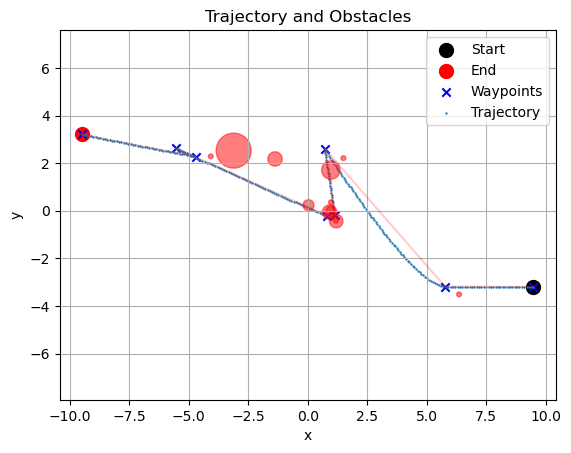

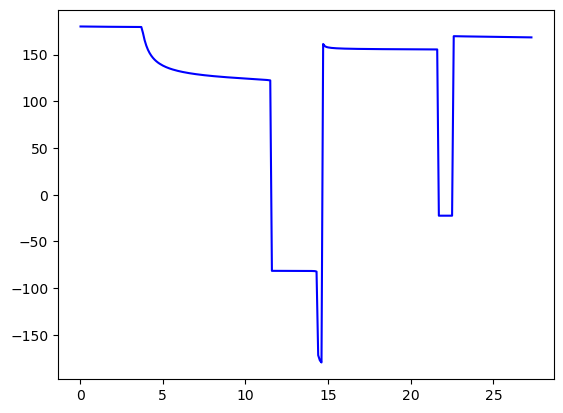

In [38]:
import numpy as np
import scipy.interpolate as interp
import matplotlib.pyplot as plt

np.seterr(all='ignore')
np.set_printoptions(precision=3, suppress=True)

def generate_path_colav_environment(No, Nw, Lp, mu_r, sigma_d):
    # Draw theta_start from Uniform(0, 2*pi)
    theta_start = np.random.uniform(0, 2 * np.pi)

    # Path origin and goal position
    p_start = 0.5 * Lp * np.array([np.cos(theta_start), np.sin(theta_start)])
    p_end = -p_start

    # Generate Nw random waypoints between p_start and p_end
    waypoints = np.linspace(p_start, p_end, Nw) + np.random.normal(0, Lp/10, (Nw, 2))
    waypoints[0] = p_start
    waypoints[-1] = p_end

    # Create smooth arc length parameterized path using PCHIP
    p = interp.PchipInterpolator(np.linspace(0, 1, Nw), waypoints, axis=0)

    obstacles = []

    # Generate No obstacles
    for _ in range(No):
        # Draw arclength omega_obst from Uniform(0.1 * Lp, 0.9 * Lp)
        omega_obst = np.random.uniform(0.1 * Lp, 0.9 * Lp)

        # Map omega_obst to normalized arclength
        norm_omega_obst = omega_obst / Lp

        # Draw obstacle displacement distance d_obst from N(0, sigma_d^2)
        d_obst = np.random.normal(0, sigma_d**2)

        # Path angle gamma_obst
        gamma_obst = np.arctan2(p.derivative()(norm_omega_obst)[1], p.derivative()(norm_omega_obst)[0])

        # Obstacle position
        p_obst = p(norm_omega_obst) + d_obst * np.array([np.cos(gamma_obst - np.pi/2), np.sin(gamma_obst - np.pi/2)])

        # Draw obstacle radius r_obst from Poisson(mu_r)
        r_obst = np.clip(np.random.normal(mu_r, 0.3), 0.1, 1)
        
        # Add obstacle (p_obst, r_obst) to environment
        obstacles.append((p_obst, r_obst))

    return waypoints, p, obstacles

def arc_length(path, t, dt):
    derivative = path.derivative()(t)
    return np.sqrt(np.sum(derivative**2, axis=1)) * dt


# Example usage
No = 12
Nw = 8
Lp = 20
mu_r = 0.25
sigma_d = 0.8

waypoints, path, obstacles = generate_path_colav_environment(No, Nw, Lp, mu_r, sigma_d)

# Calculate even trajectory points
t = np.linspace(0, 1, 1000)
dt = t[1] - t[0]
cumulative_arclength = np.cumsum(arc_length(path, t, dt))
point_distance = 0.1
total_arclength = cumulative_arclength[-1]
num_points = int(np.ceil(total_arclength / point_distance))
even_t = np.zeros(num_points)
current_arclength = 0
for i in range(1, num_points):
    current_arclength += point_distance
    even_t[i] = np.interp(current_arclength, cumulative_arclength, t)
even_trajectory = path(even_t)
even_trajectory = np.vstack((even_trajectory, waypoints[-1]))

# Calculate yaw angles at each point
path_derivative = path.derivative()(even_t)
yaw_angles = np.arctan2(path_derivative[:, 1], path_derivative[:, 0])

# plot waypoints
plt.scatter(waypoints[0,0], waypoints[0,1], s=100, c='k',  label="Start")
plt.scatter(waypoints[-1,0], waypoints[-1,1], s=100, c='r', label="End")
plt.scatter(waypoints[:, 0], waypoints[:, 1], c='b', marker='x',label="Waypoints")
plt.plot(waypoints[:, 0], waypoints[:, 1], 'r', alpha=0.2)

# Plot the trajectory
plt.scatter(even_trajectory[:, 0], even_trajectory[:, 1], s=2, marker='.', label="Trajectory")

# Plot the arrows of yaw angles
# for i, angle in enumerate(yaw_angles):
#     x, y = even_trajectory[i]
#     dx, dy = np.cos(angle), np.sin(angle)
#     plt.arrow(x, y, dx, dy, width=0.001, fc='r', ec='r')
    
# Plot the obstacles
for p_obst, r_obst in obstacles:
    circle = plt.Circle((p_obst[0], p_obst[1]), r_obst, color='r', alpha=0.5)
    plt.gca().add_patch(circle)
    # plt.scatter(p_obst[0], p_obst[1], s=100, c='r', label="Obstacle")

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Trajectory and Obstacles")
plt.axis("equal")
plt.grid()

even_arclength = np.interp(even_t, t, cumulative_arclength)
# print(cumulative_arclength)
# print(even_arclength)

print(even_trajectory[2])
print(even_trajectory[3])
fig, ax = plt.subplots()
yaw_angles_in_degrees = np.rad2deg(yaw_angles)
plt.plot(even_arclength, yaw_angles_in_degrees, 'b-', label="Yaw angle")

plt.show()


In [16]:
print(np.linalg.norm(even_trajectory[2] - even_trajectory[3]))

0.0994354865167848


In [40]:
print(even_trajectory.shape)
print(waypoints.shape)
print(even_arclength.shape)
print(yaw_angles.shape)

differences = np.linalg.norm(np.diff(even_trajectory, axis=0), axis=1)
trajectory_length_at_each_point = np.cumsum(differences)
print(trajectory_length_at_each_point.shape)
print(even_arclength.shape)

print(waypoints[0])
print(even_trajectory[0])

(275, 2)
(8, 2)
(274,)
(274,)
(274,)
(274,)
[ 9.473 -3.204]
[ 9.473 -3.204]


27.2631439482627


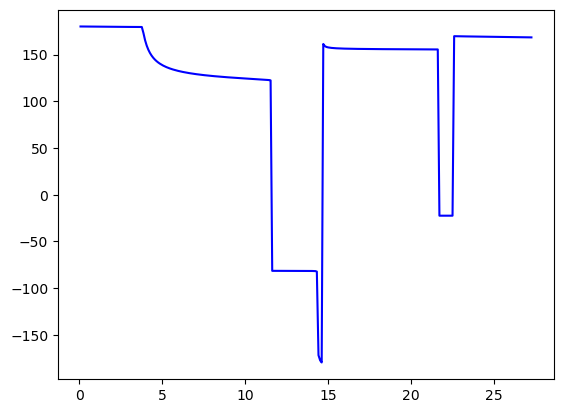

In [41]:
print(trajectory_length_at_each_point[-1])
plt.plot(trajectory_length_at_each_point, yaw_angles_in_degrees, 'b-', label="Yaw angle")


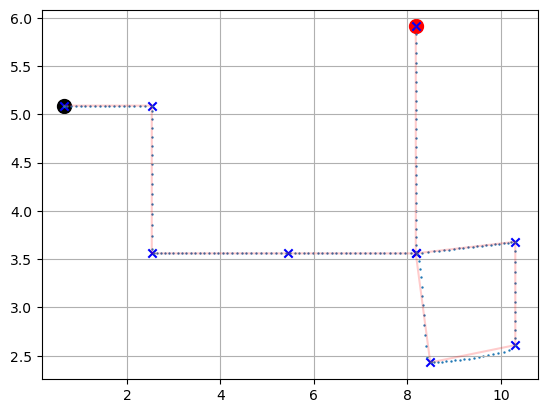

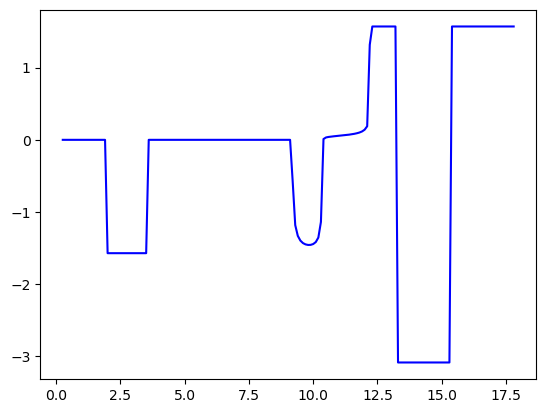

In [3]:
x = np.array([0.66, 2.53, 2.53, 5.44, 8.18, 8.49, 10.31, 10.31, 8.18, 8.18])
y = np.array([5.09, 5.09, 3.56, 3.56, 3.56, 2.43, 2.61, 3.68, 3.56, 5.91])
Nw = len(x)
waypoints = np.column_stack((x, y))
path = interp.PchipInterpolator(np.linspace(0, 1, Nw), waypoints, axis=0)
# Calculate even trajectory points
t = np.linspace(0, 1, 100)
dt = t[1] - t[0]
cumulative_arclength = np.cumsum(arc_length(path, t, dt))
point_distance = 0.1
total_arclength = cumulative_arclength[-1]
num_points = int(np.ceil(total_arclength / point_distance))
even_t = np.zeros(num_points)
current_arclength = 0
for i in range(1, num_points):
    current_arclength += point_distance
    even_t[i] = np.interp(current_arclength, cumulative_arclength, t)
even_trajectory = path(even_t)

# calculate yaw angles at each point
even_arclength = np.interp(even_t, t, cumulative_arclength)
# Calculate yaw angles at each point
path_derivative = path.derivative()(even_t)
yaw_angles = np.arctan2(path_derivative[:, 1], path_derivative[:, 0])

# plot waypoints
plt.scatter(waypoints[0,0], waypoints[0,1], s=100, c='k',  label="Start")
plt.scatter(waypoints[-1,0], waypoints[-1,1], s=100, c='r', label="End")
plt.scatter(waypoints[:, 0], waypoints[:, 1], c='b', marker='x',label="Waypoints")
plt.plot(waypoints[:, 0], waypoints[:, 1], 'r', alpha=0.2)
# Plot the trajectory
plt.scatter(even_trajectory[:, 0], even_trajectory[:, 1], s=2, marker='.', label="Trajectory")
plt.grid()

fig, ax = plt.subplots()
plt.plot(even_arclength, yaw_angles, 'b-', label="Yaw angle")

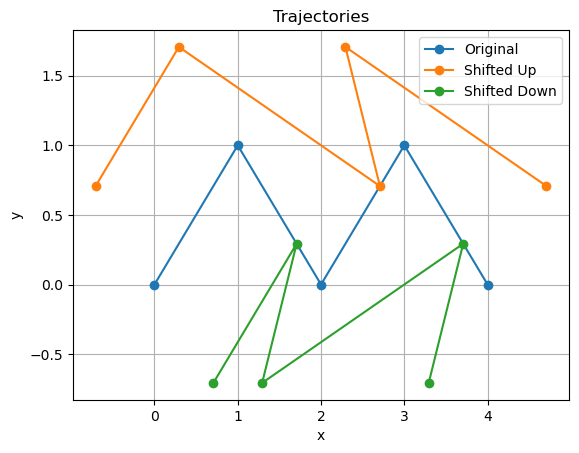

In [285]:
import numpy as np
import matplotlib.pyplot as plt

def perpendicular_shift(points, distance):
    n = len(points)
    normals = np.zeros((n, 2))

    # Calculate normal for the first point
    d_first = (points[1] - points[0]) / np.linalg.norm(points[1] - points[0])
    normals[0] = np.array([-d_first[1], d_first[0]])

    for i in range(1, n - 1):
        p1 = points[i - 1]
        p2 = points[i]
        p3 = points[i + 1]

        # Calculate the normalized direction vector for the current segment
        d1 = (p2 - p1) / np.linalg.norm(p2 - p1)

        # Find the normal vector
        normal = np.array([-d1[1], d1[0]])

        normals[i] = normal

    # Calculate normal for the last point
    d_last = (points[-1] - points[-2]) / np.linalg.norm(points[-1] - points[-2])
    normals[-1] = np.array([-d_last[1], d_last[0]])

    # Shift points up and down
    shifted_points_up = points + distance * normals
    shifted_points_down = points - distance * normals

    return shifted_points_up, shifted_points_down

# Example usage:
points = np.array([(0, 0), (1, 1), (2, 0), (3, 1), (4, 0)])
distance = 1

shifted_points_up, shifted_points_down = perpendicular_shift(points, distance)

# Plot the trajectories
plt.plot(points[:, 0], points[:, 1], 'o-', label='Original')
plt.plot(shifted_points_up[:, 0], shifted_points_up[:, 1], 'o-', label='Shifted Up')
plt.plot(shifted_points_down[:, 0], shifted_points_down[:, 1], 'o-', label='Shifted Down')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories')
plt.grid()
plt.show()


# Bounding trajectories

Computation time: 0.00280 seconds
Computation time: 0.00184 seconds


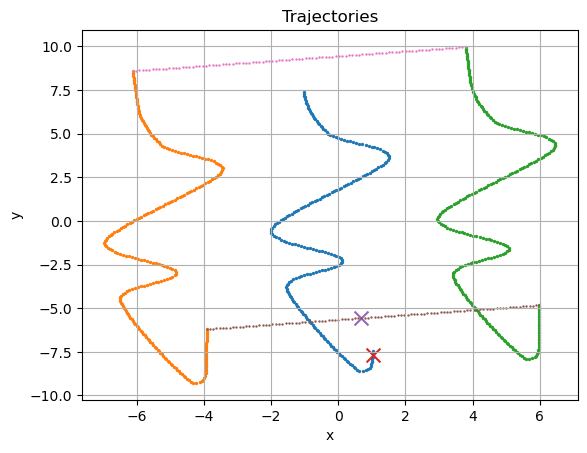

In [553]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import time

def average_direction(points):
    diff = np.diff(points, axis=0)
    avg_dir = np.mean(diff, axis=0)
    return avg_dir / np.linalg.norm(avg_dir)

def orthogonal_vector(vector):
    return np.array([-vector[1], vector[0]])

def shift_trajectory(points, distance, direction):
    return points + distance * direction

def distance_to_trajectories(point, trajectories):
    min_distance = float('inf')
    closest_trajectory = -1
    closest_point_index = -1

    for i, trajectory in enumerate(trajectories):
        distances = np.linalg.norm(trajectory - point, axis=1)
        current_min_distance = np.min(distances)
        current_closest_point_index = np.argmin(distances)

        if current_min_distance < min_distance:
            min_distance = current_min_distance
            closest_trajectory = i
            closest_point_index = current_closest_point_index

    return min_distance, closest_trajectory, closest_point_index

def extend_trajectory(points, extend_length):
    
    if extend_length == 0:
        return points
    
    distance = np.linalg.norm(points[3] - points[2])
    start_direction = (points[1] - points[0]) / np.linalg.norm(points[1] - points[0])
    end_direction = (points[-1] - points[-2]) / np.linalg.norm(points[-1] - points[-2])
    num_points_to_add = int(extend_length / distance)
    start_points = [points[0] - start_direction * distance * i for i in range(1, num_points_to_add + 1)][::-1]
    end_points = [points[-1] + end_direction * distance * i for i in range(1, num_points_to_add + 1)]

    return np.vstack([start_points, points, end_points])

def create_line_between_points(point_a, point_b, point_distance=0.1):
    distance = np.linalg.norm(point_b - point_a)
    num_points = int(np.ceil(distance / point_distance)) + 1
    t = np.linspace(0, 1, num_points)
    line_points = np.array([(1 - t_i) * point_a + t_i * point_b for t_i in t])
    return line_points

# Example usage:
points = np.array([(0, 0), (1, 1), (2, 0), (3, 1), (4, 0)])
points = even_trajectory.copy()

distance = 5

avg_dir = average_direction(points)
orthogonal_dir = orthogonal_vector(avg_dir)

shifted_points_up = shift_trajectory(points, distance, orthogonal_dir)
shifted_points_down = shift_trajectory(points, -distance, orthogonal_dir)

# Extend the trajectories
extend_length = 2
extended_shifted_points_up = extend_trajectory(shifted_points_up, extend_length)
extended_shifted_points_down = extend_trajectory(shifted_points_down, extend_length)

# Create lines connecting the starting points and ending points
start_line = create_line_between_points(extended_shifted_points_up[0], extended_shifted_points_down[0], point_distance=0.1)
end_line = create_line_between_points(extended_shifted_points_up[-1], extended_shifted_points_down[-1], point_distance=0.1)




# Closest point
sample_indexs = np.random.choice(points.shape[0], 20)
query_points = points[sample_indexs]

trajectories = [extended_shifted_points_up, extended_shifted_points_down, start_line, end_line]
# query_point = np.array([0.0, 0.0])
start_time = time.time()
for query_point in query_points:
    min_distance, closest_trajectory_index, closest_point_index = distance_to_trajectories(query_point, trajectories)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Computation time: {elapsed_time:.5f} seconds")


# Closet point using cKDTree
start_time = time.time()
all_new_trajectories = np.vstack([extended_shifted_points_up, extended_shifted_points_down, start_line, end_line])
# Store the starting indices of each trajectory in the combined array
starting_indices = [0, len(extended_shifted_points_up), 
                    len(extended_shifted_points_up) + len(extended_shifted_points_down), 
                    len(extended_shifted_points_up) + len(extended_shifted_points_down) + len(start_line)]
# Create a k-d tree
kd_tree = cKDTree(all_new_trajectories)
for query_point in query_points:
    # Query the k-d tree for the nearest point
    min_distance, index = kd_tree.query(query_point)
    closest_trajectory_index = np.searchsorted(starting_indices, index, side="right") - 1
    closest_point_index = index - starting_indices[closest_trajectory_index]
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Computation time: {elapsed_time:.5f} seconds")

# Plot the trajectories
plt.scatter(points[:, 0], points[:, 1], s=2, marker='o', label='Original')
plt.scatter(extended_shifted_points_up[:, 0], extended_shifted_points_up[:, 1], s=2, marker='o', label='Shifted Up')
plt.scatter(extended_shifted_points_down[:, 0], extended_shifted_points_down[:, 1], s=2, marker='o', label='Shifted Down')

plt.scatter(query_point[0], query_point[1], s=100, marker='x', label='Query Point')
plt.scatter(trajectories[closest_trajectory_index][closest_point_index, 0], trajectories[closest_trajectory_index][closest_point_index, 1], s=100, marker='x', label='Closest Point')

plt.scatter(start_line[:, 0], start_line[:, 1], s=2, marker='.', label='Start Line')
plt.scatter(end_line[:, 0], end_line[:, 1], s=2, marker='.', label='End Line')

# plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories')
plt.grid()
plt.show()


# cross-track error and along-track error


closed point: [-3.181  0.263]
eta: [s, x] = [-0.372  0.661]


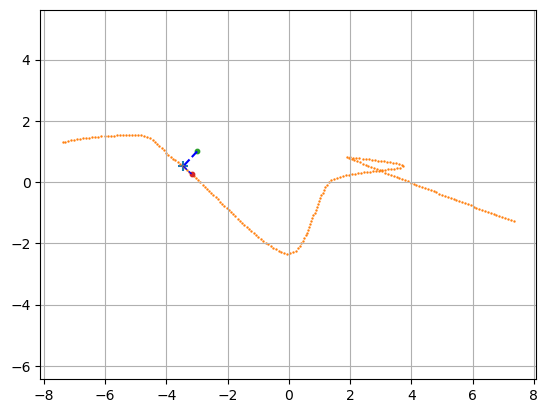

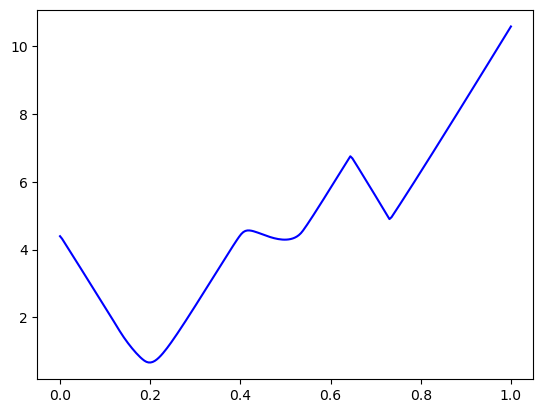

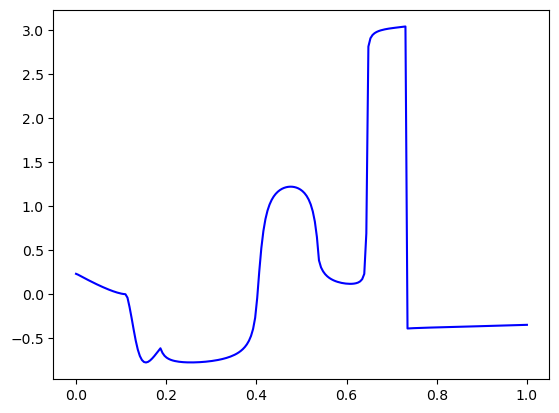

In [465]:
def distance_to_trajectory(point, trajectories):

    distances = np.linalg.norm(trajectories - point, axis=1)
    current_min_distance = np.min(distances)
    current_closest_point_index = np.argmin(distances) + 3
    closest_point = trajectories[current_closest_point_index]
    return distances, current_min_distance, current_closest_point_index, closest_point

atr_position = np.array([-3, 1])
reference_trejectory = even_trajectory.copy()
trejectory_kd_tree = cKDTree(reference_trejectory)

# Using normal distance calculation#############
# distances, min_distance, index, closest_point = distance_to_trajectory(atr_position, reference_trejectory)
###############################

## Using KD tree ################
min_distance, index = trejectory_kd_tree.query(atr_position)
index = index +3
closest_point = reference_trejectory[index]
###############################

parameter = np.linspace(0, 1, len(reference_trejectory))

closest_point_yaw_angle = yaw_angles[index]
R = np.array([[np.cos(closest_point_yaw_angle), -np.sin(closest_point_yaw_angle)],
                [np.sin(closest_point_yaw_angle), np.cos(closest_point_yaw_angle)]])
print(f"closed point: {closest_point}")
eta = R.T @ (atr_position - closest_point)
print(f"eta: [s, x] = {eta}")

s = np.array([eta[0], 0.0])
e = np.array([0.0, eta[1]])
s_global = R @ s + closest_point
e_global = R @ e + closest_point
plt.scatter(s_global[0], s_global[1], s=50, marker='+', label='Query Point')
plt.plot((atr_position[0], s_global[0]), (atr_position[1], s_global[1]), 'b--', label="Yaw angle")
plt.plot((s_global[0], closest_point[0]), (s_global[1], closest_point[1]), 'b--', linewidth=1, label="Yaw angle")

# plt.scatter(e_global[0], e_global[1], s=100, marker='x', label='Query Point')

plt.scatter(reference_trejectory[:, 0], reference_trejectory[:, 1], s=2, marker='.', label='Original')
plt.scatter(atr_position[0], atr_position[1], s=10, marker='o', label='Query Point')
plt.scatter(reference_trejectory[index, 0], reference_trejectory[index, 1], s=10, marker='o', label='Closest Point')
plt.axis('equal')
plt.grid()

plt.figure()
plt.plot(parameter, distances, 'b-', label="Yaw angle")

plt.figure()
plt.plot(parameter, yaw_angles, 'b-', label="Yaw angle")

 ## Path generate test

14.999999999999996


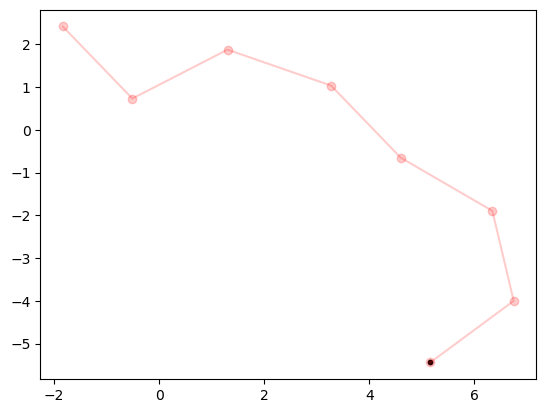

In [546]:
def generate_path_colav_environment(No, Nw, Lp, mu_r, sigma_d):
    # Draw theta_start from Uniform(0, 2*pi)
    theta_start = np.random.uniform(0, 2 * np.pi)

    # Path origin and goal position
    p_start = 0.5 * Lp * np.array([np.cos(theta_start), np.sin(theta_start)])
    p_end = -p_start

    # Generate Nw random waypoints between p_start and p_end
    waypoints = np.linspace(p_start, p_end, Nw) + np.random.normal(0, Lp/10, (Nw, 2))
    waypoints[0] = p_start
    waypoints[-1] = p_end

    return waypoints

# generate waypoints that won't go back
def generate_waypoints_not_back(Nw, Lp):
    # Generate the starting point
    theta_start = np.random.uniform(0, 2 * np.pi)
    p_start = 0.5 * Lp * np.array([np.cos(theta_start), np.sin(theta_start)])
    p_end = -p_start
    waypoints = [p_start]

    # Calculate the average segment length
    avg_segment_length = Lp / (Nw - 1)

    # Generate the remaining waypoints
    for i in range(1, Nw):  # Nw - 1 to leave space for the last waypoint (p_end)
        # Get the previous waypoint and the direction of the previous segment
        prev_waypoint = waypoints[-1]
        if i == 1:
            prev_dir = np.array([1, 0])
        else:
            prev_dir = prev_waypoint - waypoints[-2]
        
        # Generate a new waypoint in the forward direction
        while True:
            # Generate a random direction vector
            direction = np.random.rand(2) - 0.5
            direction /= np.linalg.norm(direction)

            # Check if the new waypoint is in the forward direction
            if np.dot(direction, prev_dir) >= 0:
                break
        
        # Generate a new waypoint at the average segment length and add it to the list
        new_waypoint = prev_waypoint + avg_segment_length * direction
        waypoints.append(new_waypoint)

    # Add the end point to the list of waypoints
    # waypoints.append(p_end)

    return np.array(waypoints)

# generate waypoints that can turn back
def generate_waypoints(Nw, Lp, steps_to_allow_reverse=3):
    # Generate the starting point
    start = np.array([0, 0])
    waypoints = [start]

    # Generate the remaining waypoints
    for i in range(1, Nw):
        # Get the previous waypoint and the direction of the previous segment
        prev_waypoint = waypoints[-1]
        if i == 1:
            prev_dir = np.array([1, 0])
        else:
            prev_dir = prev_waypoint - waypoints[-2]
        
        # Generate a new waypoint in the forward direction
        while True:
            # Generate a random direction vector
            direction = np.random.rand(2) - 0.5
            direction /= np.linalg.norm(direction)

            # Check if the new waypoint is in the forward direction or far enough away to allow reversing
            dot_product = np.dot(direction, prev_dir)
            if dot_product >= 0 or (dot_product < 0 and i >= steps_to_allow_reverse):
                break
        
        # Generate a new waypoint at the desired distance and add it to the list
        new_waypoint = prev_waypoint + Lp * direction
        waypoints.append(new_waypoint)

    return np.array(waypoints)

# Example usage
No = 12
Nw = 8
Lp = 15
mu_r = 0.25
sigma_d = 0.8

waypoints = generate_waypoints_not_back(Nw, Lp)
plt.scatter(waypoints[0,0], waypoints[0,1], s=10, c='k',  label="Start")
plt.plot(waypoints[:,0], waypoints[:,1], 'r', linestyle='-', marker='o', alpha=0.2)

total_distance = np.diff(waypoints, axis=0)
total_distance = np.sum(np.linalg.norm(total_distance, axis=1))
print(total_distance)